In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
F=open('/content/drive/My Drive/MLProject/text8')
data=F.read()
data=data[0:10000000]


# **Importing required packages**

In [ ]:
from collections import Counter
import random
import numpy as np
import pandas as pd

from nltk.tokenize import RegexpTokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch
import torch.nn  as  nn
import torch.optim as optim
import torch.nn.functional as F

# **#PreProcessing the data set**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
# stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def process_data(data):
  data=data.lower()
  data=data.split()
  stop_words = set(stopwords.words('english'))
  data1=[]
  for word in data:
    if word not in stop_words:
      data1.append(word)
  word_counts = Counter(data1)
  data2 = [word for word in data1 if word_counts[word] >5]
  data=data2


  E_count=1
  # dictioanry for keeping the frequency of each word
  E_wordCount={}
  # dictioanry to find the index for a word in English
  E_word2index={}

  # dictionary to find the English word for a particular index
  E_index2word={}

  for word in data:
    E_wordCount[word]= E_wordCount.get(word,0)+1
    if (word not in E_word2index.keys()): # check if the token already exists in English dictionary
      # if the token is not present in English dictionary then add it to word2index and index2word English dictionary
      E_word2index[word]= E_count
      E_index2word[E_count]=word
      E_count+=1 # increasing the count of words in English vocabulary
    else:
      E_wordCount[word]+=1 # if the token exists in dictionary then simply increase it's count of occurrence
  return data,E_wordCount,E_word2index,E_index2word


In [ ]:

processed_data,E_wordCount,E_word2index,E_index2word=process_data(data)

In [ ]:
word=[word for word in processed_data]
vocab=set(word)
print(len(word))
print("vocab size:",len(vocab))
V=len(vocab)

997396
vocab size: 17039


# **Subsampling**

In [ ]:
wordinint=[]
for word in processed_data:
  wordinint.append(E_word2index[word])

threshold = 1e-5
word_counts = Counter(wordinint)
total_count = len(processed_data)
freq={}
for word,count in word_counts.items():
  freq[word]=count/total_count
print(freq[1])
p_drop = {word: 1 - np.sqrt(threshold/freq[word]) for word,_ in word_counts.items()}
train_words = [word for word in wordinint if random.random() < (1 - p_drop[word])]

print(train_words[:30])

0.00015740989536753707
[2, 4, 10, 14, 18, 19, 29, 30, 31, 33, 36, 37, 38, 1, 44, 48, 49, 54, 55, 61, 62, 63, 56, 69, 70, 33, 54, 76, 80, 33]


# **Genrating data pairs**

In [ ]:
tuples = []
w = 3
for i, word in enumerate(train_words):
  start = max(0,i-w)
  end = min(i+w, len(train_words))
  for j in range(start,end):
    if i!=j:
      tuples.append((word, train_words[j]))
print("There are {} pairs ".format(len(tuples)))

There are 1454251 pairs 


# **Model**

In [ ]:

class W2V_NS(nn.Module):

    def __init__(self, embedding_size, vocab_size,batch_size):
        super(W2V_NS, self).__init__()
        #embeddding 1 for word representation vector
        #embedding 2 for context representation vector
        self.embeddings1 = nn.Embedding(vocab_size, embedding_size)
        self.embeddings2 = nn.Embedding( vocab_size,embedding_size)
        self.embedding_size=embedding_size
        self.batch_size=batch_size

        #initialising weights
        self.embeddings1.weight.data.uniform_(-1,1)
        self.embeddings2.weight.data.uniform_(-1,1)

    #function for negative samples
    def neg_sample(self,batch_size,sample_size):
      noise_d = torch.ones(V)
      neg_words = torch.multinomial(noise_d,
                                        batch_size * sample_size,
                                        replacement=True)
      neg_words = torch.tensor(neg_words)
      neg_vec = self.embeddings2(neg_words).view(batch_size,sample_size,self.embedding_size)   

      return neg_vec     
        

    #function for positive samples    
    def forward(self,target,context):
        emb1 = self.embeddings1(target)
        emb2 = self.embeddings2(context)
        # print(emb1.shape)
        emb1 = emb1.view(emb1.shape[0], self.embedding_size, 1)
        emb2 = emb2.view(emb2.shape[0], 1,self.embedding_size) 
        
        # out = F.log_softmax(hidden)

        neg_vec=self.neg_sample(target.shape[0],5)

        #calculating output loss for true class
        o_loss = torch.bmm(emb2, emb1).sigmoid().log()
        o_loss = o_loss.squeeze()
        # print(out_loss.shape)

        #calculating negative loss
        n_loss = torch.bmm(neg_vec.neg(), emb1).sigmoid().log()
        n_loss = n_loss.squeeze().sum(1)
        return -(o_loss+n_loss).mean()

    def repre(self,x):
        return self.embeddings1(x)

    

# **Training the model**

In [ ]:
batch_size=1024
w2v=W2V_NS(100,V+1,batch_size)
data=[]
for i in range(0,len(tuples)):
  t=[]
  # x=np.zeros(V)
  # x[context_tuple_list[j][0]]=1
  t.append(tuples[j][0])
  t.append(tuples[j][1])
  data.append(t)


In [ ]:

train_iter = DataLoader(data, batch_size=1024,shuffle=True) 

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.AdamW(w2v.parameters(), lr=0.001) # AdamW optimizer is used 



In [ ]:
path = "/content/drive/My Drive/MLProject/NSmodel"
path5 = "/content/drive/My Drive/MLProject/NSmodel5"
path10 = "/content/drive/My Drive/MLProject/NSmodel10"
path15 = "/content/drive/My Drive/MLProject/NSmodel15"
path20 = "/content/drive/My Drive/MLProject/NSmodel20"
path25 = "/content/drive/My Drive/MLProject/NSmodel25"
path30 = "/content/drive/My Drive/MLProject/NSmodel30"
path35 = "/content/drive/My Drive/MLProject/NSmodel35"

In [ ]:
import time
training_loss=[]
sum=0
epochs=26
for epoch in range(epochs):
  l=0
  t0 = time.time()
  for id, (x,y) in enumerate(train_iter): 
    # print(type(x))
    # print(x,y)
    loss=w2v(x,y) #loss
    optimizer.zero_grad() 
    # loss=criterion(output,y) 
    loss.backward() #gradient descent
    optimizer.step() 
    l=l+loss.item()
    del x,y
  if(epoch==5): # saving the model after every 5 epochs 
    torch.save(w2v,path5)
  elif(epoch==10):
    torch.save(w2v,path10)
  elif(epoch==15):
    torch.save(w2v,path15)
  elif(epoch==20):
    torch.save(w2v,path20)
  elif(epoch==25):
    torch.save(w2v,path25)
  elif(epoch==30):
    torch.save(w2v,path30)
  elif(epoch==35):
    torch.save(w2v,path35)
  training_loss.append(l)    

  print("epoch:",epoch,":",l)
  print('Time taken :  {} seconds'.format(time.time() - t0))
  sum=sum+time.time()-t0
print("averge time taken by epoch:",sum/epochs)



    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 : 903.4513377510011
Time taken :  82.31295657157898 seconds
epoch: 1 : 10.063468308886513
Time taken :  81.8262619972229 seconds
epoch: 2 : 5.881411348120309
Time taken :  83.47013926506042 seconds
epoch: 3 : 4.5277154867653735
Time taken :  82.08239412307739 seconds
epoch: 4 : 3.9757325349200983
Time taken :  81.85640096664429 seconds
epoch: 5 : 3.977596771263052
Time taken :  81.95417547225952 seconds
epoch: 6 : 3.579606423751102
Time taken :  81.80792927742004 seconds
epoch: 7 : 3.908983647444984
Time taken :  81.93975710868835 seconds
epoch: 8 : 3.518051748193102
Time taken :  82.28950309753418 seconds
epoch: 9 : 3.6791429427539697
Time taken :  82.1966061592102 seconds
epoch: 10 : 3.572343989246292
Time taken :  82.7638669013977 seconds
epoch: 11 : 4.064247692658682
Time taken :  82.33053231239319 seconds
epoch: 12 : 3.666753942539799
Time taken :  82.66453862190247 seconds
epoch: 13 : 3.6564047707943246
Time taken :  82.68554878234863 seconds
epoch: 14 : 3.68166349161765

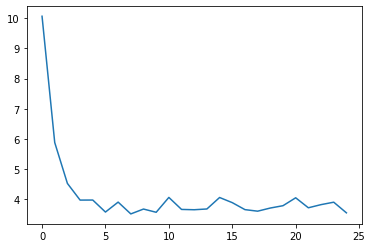

In [ ]:
plt.plot(range(len(training_loss[1:])),training_loss[1:])

# **Visualising Word2Vec word vectors**

In [ ]:
X=[]
y=[]
count=0
for word in vocab:
  if(count>100):
    break
  i=E_word2index[word]
  # print(i)
  t=w2v.repre(torch.tensor(i))
  X.append(t.tolist())
  y.append(word)
  count=count+1

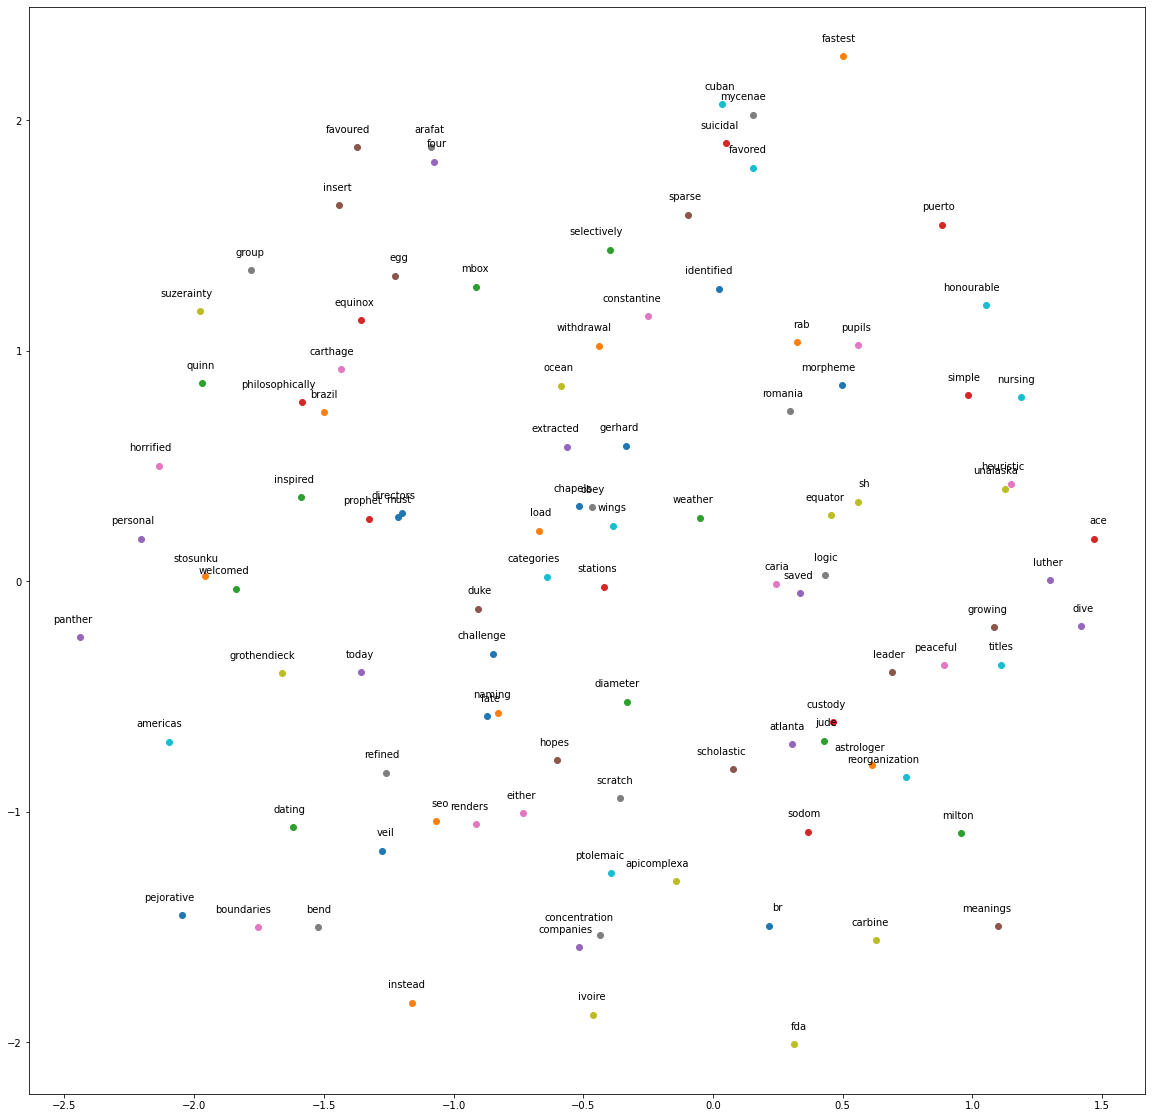

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
values = tsne_model.fit_transform(X)

x1 = []
x2= []
for value in values:
    x1.append(value[0])
    x2.append(value[1])
    
plt.figure(figsize=(20, 20)) 
for i in range(len(X)):
    plt.scatter(x1[i],x2[i])
    plt.annotate(y[i],
                  xy=(x1[i], x2[i]),
                  xytext=(13, 13),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.show()

# **Sentiment analysis**

In [ ]:
file1 = open('/content/drive/MyDrive/Unsupervised learning encoder/1000.pos') 
file2 = open('/content/drive/MyDrive/Unsupervised learning encoder/1000.neg') 
file3 = open('/content/drive/MyDrive/Unsupervised learning encoder/100.pos') 
file4 = open('/content/drive/MyDrive/Unsupervised learning encoder/100.neg') 

def processing(F):
  x=[]
  for line in F:
    l=line.split()
    stop_words = set(stopwords.words('english'))
    d1=[]
    for word in l:
     if word not in stop_words:
        if(word  in vocab):
          d1.append(E_word2index[word])
        else:
          d1.append(0)
    x.append(d1)
  return x
  

In [ ]:
train_data=processing(file1)
print(len(train_data))
train_data=train_data+processing(file2)

1000


In [ ]:
test_data=processing(file3)
test_data=test_data+processing(file4)
len(test_data)

200

In [ ]:
train_label=[1]*1000+[0]*1000
test_label=[1]*100+[0]*100
len(train_label)

2000

# **applying word2vec to get sentence represenation**

In [ ]:
embedding_size=100
def avg_vectors(X):
  data=[]
  for l in X:
    v=[]
    for i in l:
      v.append(w2v.repre(torch.tensor(i)).tolist())
    avg_vec=np.mean(np.array(v),axis=0)
    data.append(avg_vec)
  return data




In [ ]:
train=avg_vectors(train_data)
test=avg_vectors(test_data)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=200).fit(train, train_label)

In [ ]:
#accuracy on training data
print("accuracy on training set",clf.score(train,train_label))

accuracy on training set 0.761


In [ ]:
print("accuracy on test data",clf.score(test,test_label))

accuracy on test data 0.735


References


[Word2vec from Scratch with Python and NumPy](https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/)


[implementation of word2vec Paper](https://www.kaggle.com/ashukr/implementation-of-word2vec-paper)